In [1]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
from keras import regularizers ### for SVM
import numpy as np
import tensorflow as tf
# import theano
import  matplotlib.pyplot as plt
import matplotlib
import itertools
from numpy import*
from sklearn.utils import shuffle
%matplotlib inline
import random as rn
import os
from keras.models import load_model

tf.reset_default_graph()


from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from models.cnn import mini_XCEPTION
from utils.datasets import DataManager
from utils.preprocessor import preprocess_input


Using TensorFlow backend.


In [2]:
## load dataset 
trainingset = np.loadtxt('Dataset/fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('Dataset/fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[  70.,   80.,   82., ...,    0.,    0.,    0.],
       [ 151.,  150.,  147., ...,    0.,    0.,    0.],
       [ 231.,  212.,  156., ...,    0.,    0.,    0.],
       ..., 
       [  74.,   81.,   87., ...,    1.,    0.,    0.],
       [ 222.,  227.,  203., ...,    0.,    0.,    0.],
       [ 195.,  199.,  205., ...,    1.,    0.,    0.]])

In [3]:
## tranfer data 
n_inputs = 2304   #### 48X48X1
n_classes = 7
img_dim = 48

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

x_training = x_training.reshape(x_training.shape[0], 48, 48)
x_training = np.expand_dims(x_training, axis=4)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
x_testing = np.expand_dims(x_testing, axis=4)

In [18]:
print(x_training.shape[0],x_training.shape[1], x_training.shape[2],x_training.shape[3] )
print(x_testing.shape[0], x_testing.shape[1], x_testing.shape[2], x_testing.shape[3] )

28709 48 48 1
3589 48 48 1


In [5]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [6]:
##### 
def get_emotion(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

In [7]:
input_shape = (48, 48, 1)
num_classes = 7

In [8]:
model = mini_XCEPTION(input_shape, num_classes)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 46, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
opt = Adam(lr=0.001, decay=10e-6)

model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

In [12]:
batch_size = 128
n_epoches = 500

from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "weights.emotion.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
history = model.fit_generator(data_generator.flow(x_training, y_training, batch_size), steps_per_epoch=int(len(x_training) / batch_size), validation_data = (x_testing, y_testing), epochs=n_epoches, shuffle=True, callbacks = callbacks_list, verbose =2)

Epoch 1/500
 - 29s - loss: 1.8222 - acc: 0.3034 - val_loss: 3.2652 - val_acc: 0.2661

Epoch 00001: val_acc improved from -inf to 0.26609, saving model to weights.emotion.best.hdf5
Epoch 2/500
 - 26s - loss: 1.6166 - acc: 0.3978 - val_loss: 2.0323 - val_acc: 0.3589

Epoch 00002: val_acc improved from 0.26609 to 0.35887, saving model to weights.emotion.best.hdf5
Epoch 3/500
 - 26s - loss: 1.5038 - acc: 0.4426 - val_loss: 1.6742 - val_acc: 0.4288

Epoch 00003: val_acc improved from 0.35887 to 0.42881, saving model to weights.emotion.best.hdf5
Epoch 4/500
 - 26s - loss: 1.4329 - acc: 0.4659 - val_loss: 1.6699 - val_acc: 0.3962

Epoch 00004: val_acc did not improve
Epoch 5/500
 - 26s - loss: 1.3683 - acc: 0.4897 - val_loss: 1.4670 - val_acc: 0.4553

Epoch 00005: val_acc improved from 0.42881 to 0.45528, saving model to weights.emotion.best.hdf5
Epoch 6/500
 - 26s - loss: 1.3359 - acc: 0.5003 - val_loss: 1.4402 - val_acc: 0.4639

Epoch 00006: val_acc improved from 0.45528 to 0.46392, saving 

In [13]:
scores = model.evaluate(x_testing, y_testing)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))


3589/3589 [==============================] - 1s 179us/step
acc: 63.19%


In [14]:
model.load_weights('weights.emotion.best.hdf5')

In [15]:
scores = model.evaluate(x_testing, y_testing)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

3589/3589 [==============================] - 1s 170us/step
acc: 64.14%


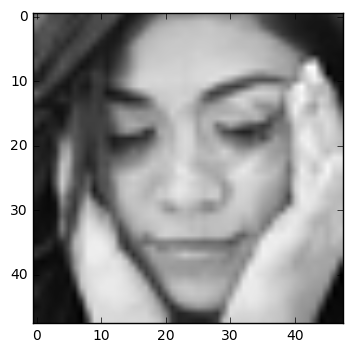

> testing image index: 580
> true emotion: fear
> predicted emotion: sad


In [19]:
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

y_pred1 = model.predict(sample.reshape(1, 48, 48, 1))
pred_cls = np.argmax(y_pred1,axis=1)
plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))